In [1]:
# Ignore dumb warning through the iterations
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# General libraries
import numpy as np
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
import joblib

# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score

# Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC

LDA
QDA


In [17]:
aux = pd.read_csv('../data/clean_data.csv', index_col='Municipality')
aux[['culture_knowledge_of_catalan_speak', 'population_population_by_sex_total']].corr()

,culture_knowledge_of_catalan_speak,population_population_by_sex_total
culture_knowledge_of_catalan_speak,1.000000,-0.187062
population_population_by_sex_total,-0.187062,1.000000


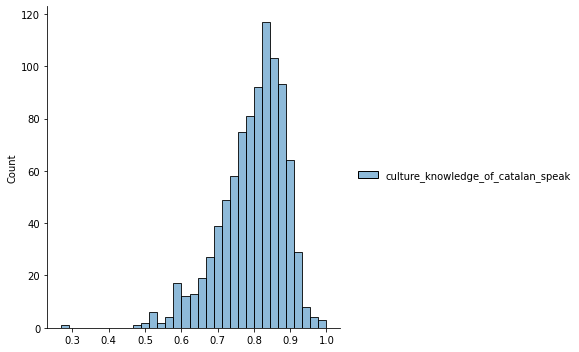

In [7]:
# Get data
df = pd.read_csv('../data/clean_data.csv', index_col='Municipality')
dg = pd.read_csv('../data/model_data.csv', index_col='Municipality')
# dg.head()

# Get proper label
labels = df.filter(like='catalan')
label = df.filter(like='catalan').filter(like='speak')
df = df.loc[:, ~df.columns.isin(labels.columns)]

data = label.join(dg, on='Municipality')
# data.head()

# Get trainin data and label
label = data['culture_knowledge_of_catalan_speak'].to_frame()
data = data.drop(['culture_knowledge_of_catalan_speak'], axis=1)

sns.displot(label)

label[:] = pd.qcut(label['culture_knowledge_of_catalan_speak'], q=4, labels=[0,1,2,3])
label[label['culture_knowledge_of_catalan_speak'] == 2] = 1
label[label['culture_knowledge_of_catalan_speak'] == 3] = 2

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)

Logistic Regression

In [10]:
from scipy.stats import loguniform

start_time = time.time()
model = LogisticRegression(random_state=42, max_iter=500)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = [
    {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': loguniform(1e-1, 100), 'class_weight': [None, 'balanced']},
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': loguniform(1e-1, 100), 'class_weight': [None, 'balanced']},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': loguniform(1e-1, 100), 'class_weight': [None, 'balanced']}
    # {'solver': ['saga'], 'penalty': ['elasticnet', 'l1', 'l2', 'none'], 'C': loguniform(1e-3, 100), 'class_weight': [None, 'balanced']}
]

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6742571630246204
Best Hyperparameters: {'C': 0.17728580556091045, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
Time: 120.9025628566742


In [281]:
joblib.dump(search, '../pickles/search_lr.pkl')

['../pickles/search_lr.pkl']

In [282]:
# def plot_grid_results(grid):
#     import pandas as pd
    
#     data = pd.DataFrame(grid.cv_results_).filter(regex=r'mean_test_score|std_test_score|param_')
#     return data 

# df = plot_grid_results(search)
# df.head()

,param_C,param_class_weight,param_penalty,param_solver,mean_test_score,std_test_score
0,9.609813,None,l1,liblinear,0.672398,0.049490
1,0.964386,balanced,l2,newton-cg,0.666600,0.051456
2,0.003161,None,l2,liblinear,0.640389,0.053872
3,1.01292,balanced,l2,newton-cg,0.667650,0.051950
4,0.001267,balanced,l2,liblinear,0.609054,0.057201


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

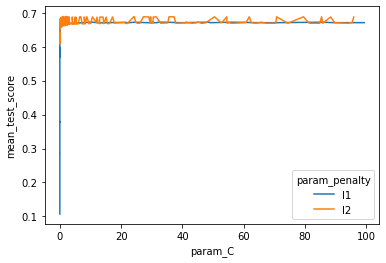

In [283]:
# sns.lineplot(x='param_C', y='mean_test_score', hue='param_penalty', data=df)

In [209]:
start_time = time.time()
model = SGDClassifier(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'loss': ['log', 'hinge', 'perceptron'],
    'penalty': ['elasticnet', 'l2'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
    'class_weight': [None, 'Balanced']
}

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6841059900282452
Best Hyperparameters: {'penalty': 'elasticnet', 'loss': 'log', 'l1_ratio': 0.5, 'alpha': 0.1}
Time: 11.808224201202393


In [ ]:
joblib.dump(search, '../pickles/search_sgd.pkl')

In [188]:
start_time = time.time()
model = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'n_neighbors': range(2, 30, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'kd_tree']
}

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.542728167025737
Best Hyperparameters: {'n_neighbors': 12}
Time: 1.7600748538970947


In [ ]:
joblib.dump(search, '../pickles/search_knn.pkl')

In [191]:
start_time = time.time()
model = DecisionTreeClassifier(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
}

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.5301118954953091
Best Hyperparameters: {'max_depth': 4, 'criterion': 'entropy'}
Time: 4.242457151412964


In [ ]:
joblib.dump(search, '../pickles/search_dt.pkl')

In [194]:
start_time = time.time()
model = RandomForestClassifier(oob_score=True, random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

search = RandomizedSearchCV(model, random_grid, n_iter=100, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.5461470396315933
Best Hyperparameters: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}
Time: 5281.927545309067


In [ ]:
joblib.dump(search, '../pickles/search_rf.pkl')

In [ ]:
start_time = time.time()
model = SVC(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'decision_function_shape': ['ovr', 'ovo']},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'decision_function_shape': ['ovr', 'ovo']},
    {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'decision_function_shape': ['ovr', 'ovo']}
]

search = RandomizedSearchCV(model, random_grid, n_iter=100, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

In [ ]:
joblib.dump(search, '../pickles/search_svm.pkl')

In [2]:
import joblib

search = joblib.load('../pickles/search_svm.pkl')

In [4]:
search.best_score_

0.6834732407388991